In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import read_quote      as rq
import stock_functions as sf
import df_visualizations as dv
import remap_values as rv

import random
import pickle

import sys
import time

In [2]:
from sklearn.svm            import SVR
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble       import BaggingRegressor
from sklearn.ensemble       import AdaBoostRegressor

from sklearn.utils          import shuffle

from sklearn.metrics        import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.multioutput    import MultiOutputRegressor

In [3]:
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 10)

In [4]:
roll_nums = [5,15]#[3,5,7,10,12,15,18,20,22,25,28,30] # Generate an algorithm for predicting every few days
mom_nums  = [3,5,10,20,30]                     # Momentum has many good tracers
rsi_nums  = [10,15]                            # Good for some long term trends
band_nums = [5,10,15,20,25]                    # A few trace different areas well

In [5]:
inpFileList = ['aapl','acm' ,'awk' ,'amzn','awr' ,'ba'  ,'bac' ,'c'   ,'cat' ,'cop' ,'cvx' ,'dal' ,
               'dd'  ,'farm','fdp' ,'gnc' ,'hes' ,'ibm' ,'mas' ,'mcd' ,'mon' ,'msex','msft','nflx',
               'sbux','strl','tgt' ,'tsla','ups' ,'xom' ,'xpo' ,'vmc' ]

In [6]:
scaled_df = sf.get_scaled_data( inpFileList, roll_nums, mom_nums, rsi_nums, band_nums )

In [7]:
from sklearn.decomposition import PCA

In [8]:
mom_list  = ['momentum_3', 'momentum_5', 'momentum_10', 'momentum_20', 'momentum_30']
rsi_list  = ['rsi_10', 'rsi_15']
band_list = ['bollinger_5', 'bollinger_10', 'bollinger_15', 'bollinger_20', 'bollinger_25']

for col in band_list:
    scaled_df[col] = ( scaled_df[col] - scaled_df[col].mean() ) / scaled_df[col].std() 
    
mom_pca = PCA( n_components=2 )
rsi_pca = PCA( n_components=1 )
ban_pca = PCA( n_components=2 )

mom_pca.fit( scaled_df[ mom_list] )
rsi_pca.fit( scaled_df[ rsi_list] )
ban_pca.fit( scaled_df[band_list] )

print mom_pca.explained_variance_ratio_
print rsi_pca.explained_variance_ratio_
print ban_pca.explained_variance_ratio_

mom_cols = mom_pca.transform( scaled_df[ mom_list ] )
rsi_cols = rsi_pca.transform( scaled_df[ rsi_list ] )
ban_cols = ban_pca.transform( scaled_df[band_list ] )

for i in range( 0, mom_cols.shape[1] ):
    scaled_df['momentum_pca_'+str(i)] = mom_cols[:,i]
for i in range( 0, rsi_cols.shape[1] ):
    scaled_df[     'rsi_pca_'+str(i)] = rsi_cols[:,i]
for i in range( 0, ban_cols.shape[1] ):
    scaled_df[    'band_pca_'+str(i)] = ban_cols[:,i]
    
scaled_df = scaled_df.drop( mom_list+rsi_list+band_list, axis=1 )

[ 0.74639702  0.13580214]
[ 0.90273015]
[ 0.86461952  0.10455055]


In [10]:
# Read in each stock, and perform reduction
#    Break into train, test sets
#    Store train, test sets in arrays
# For each regressor predicting a certain num of days...
#    Manually cross validate, testing and scoring each set

In [9]:
# Mix up the list
shuff_scaled_df = shuffle( scaled_df, random_state=0 )

n_elements = shuff_scaled_df.shape[0]

# Set the fraction of data we will train over
percent_train = 0.7

# Size of training set
n_train = int( percent_train * n_elements )

train_df = shuff_scaled_df[ :  n_train   ]
test_df  = shuff_scaled_df[    n_train : ]

In [56]:
train_x = train_df.dropna().drop( ['close','close_mean_5','close_mean_15'],axis=1 ).values
test_x  =  test_df.dropna().drop( ['close','close_mean_5','close_mean_15'],axis=1 ).values

train_y = train_df.dropna()['close_mean_15'].values
test_y  =  test_df.dropna()['close_mean_15'].values

In [59]:
# Adaboosted random forest was the best performer

In [60]:
ad_reg = AdaBoostRegressor( base_estimator=RandomForestRegressor( n_estimators=20, max_features=0.7 ), random_state=0, 
                            loss='exponential', n_estimators=10 )

ad_reg.fit( train_x, train_y )

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         learning_rate=1.0, loss='exponential', n_estimators=10,
         random_state=0)

In [62]:
#nn_y = nn_reg.predict( test_x )
rf_y = rf_reg.predict( test_x )
ba_y = ba_reg.predict( test_x )
#sv_y = sv_reg.predict( test_x )
#bs_y = bs_reg.predict( test_x )
ad_y = ad_reg.predict( test_x )

In [63]:
avg  = ( rf_y + ba_y + ad_y )/3.0

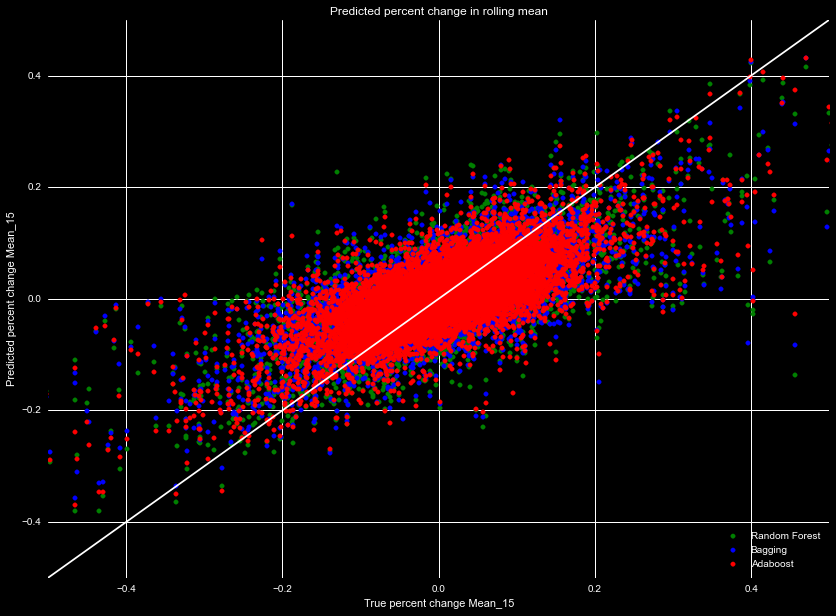

In [68]:
# Plot the data

#plt.scatter( test_y,  sv_y, color='c', label='Support Vector' )
#plt.scatter( test_y,  nn_y, color='r', label='Neural Network' )
plt.scatter( test_y,  rf_y, color='g', label='Random Forest'  )
plt.scatter( test_y,  ba_y, color='b', label='Bagging'        )
plt.scatter( test_y,  ad_y, color='r', label='Adaboost'       )
#plt.scatter( test_y,   avg, color='r', label='Average'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [low,hi], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(low,hi)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('True percent change Mean_15')
plt.ylabel('Predicted percent change Mean_15')
plt.title('Predicted percent change in rolling mean')
plt.show()

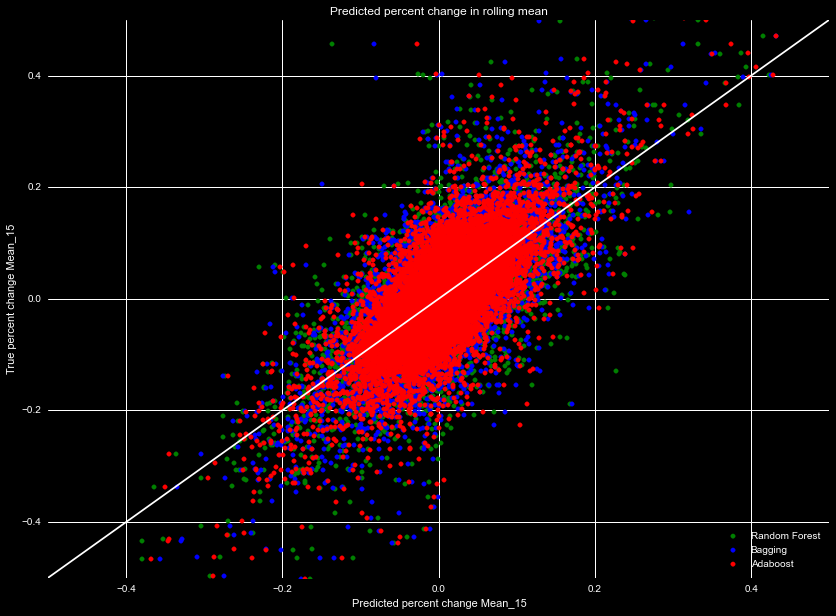

In [69]:
# Plot the data

#plt.scatter( sv_y, test_y, color='c', label='Support Vector' )
#plt.scatter( nn_y, test_y, color='r', label='Neural Network' )
plt.scatter( rf_y, test_y, color='g', label='Random Forest'  )
plt.scatter( ba_y, test_y, color='b', label='Bagging'        )
plt.scatter( ad_y, test_y, color='r', label='Adaboost'       )
#plt.scatter(  avg, test_y, color='r', label='Average'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [low,hi], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(low,hi)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('True percent change Mean_15')
plt.xlabel('Predicted percent change Mean_15')
plt.title('Predicted percent change in rolling mean')
plt.show()

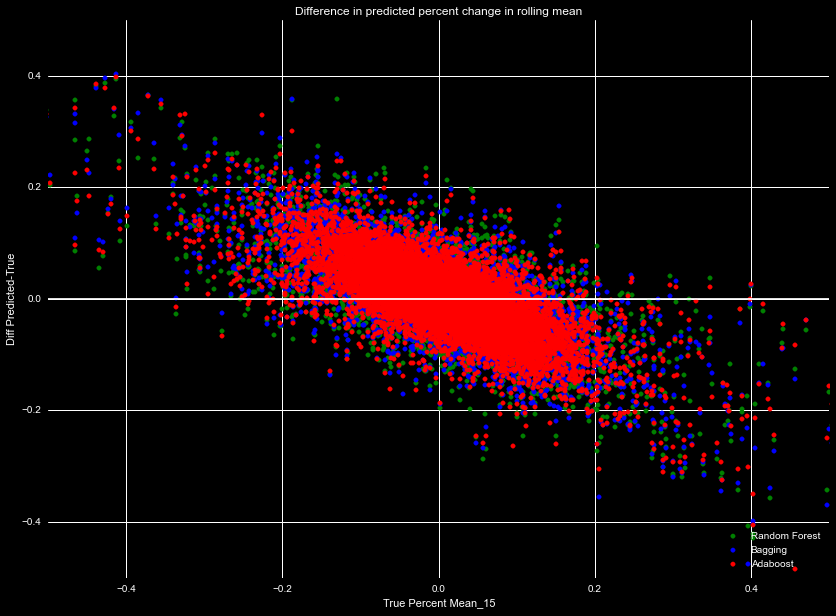

In [70]:
# Plot the data

#plt.scatter( test_y,  sv_y-test_y, color='c', label='Support Vector' )
#plt.scatter( test_y,  nn_y-test_y, color='r', label='Neural Network' )
plt.scatter( test_y,  rf_y-test_y, color='g', label='Random Forest'  )
plt.scatter( test_y,  ba_y-test_y, color='b', label='Bagging'        )
plt.scatter( test_y,  ad_y-test_y, color='r', label='Adaboost'       )
#plt.scatter( test_y,   avg-test_y, color='r', label='Average'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [0,0], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(-0.5,0.5)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('True Percent Mean_15')
plt.ylabel('Diff Predicted-True')
plt.title('Difference in predicted percent change in rolling mean')
plt.show()

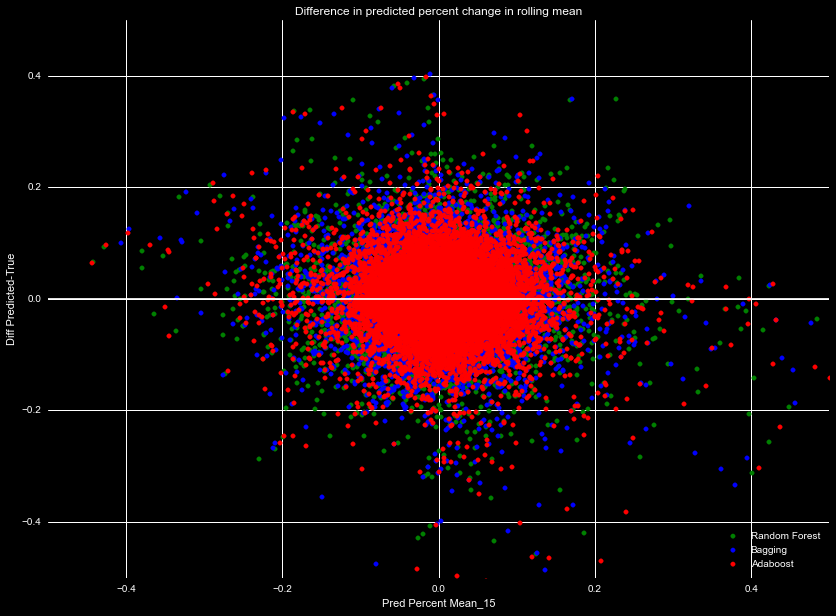

In [71]:
# Plot the data

#plt.scatter( sv_y,  sv_y-test_y, color='c', label='Support Vector' )
#plt.scatter( nn_y,  nn_y-test_y, color='r', label='Neural Network' )
plt.scatter( rf_y,  rf_y-test_y, color='g', label='Random Forest'  )
plt.scatter( ba_y,  ba_y-test_y, color='b', label='Bagging'        )
plt.scatter( ad_y,  ad_y-test_y, color='r', label='Adaboost'       )
#plt.scatter(  avg,   avg-test_y, color='r', label='Average'        )

low =-0.5
hi  = 0.5

plt.plot( [low,hi], [0,0], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(-0.5,0.5)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Pred Percent Mean_15')
plt.ylabel('Diff Predicted-True')
plt.title('Difference in predicted percent change in rolling mean')
plt.show()

In [252]:
# Don't worry about that linear transform. Predicted vs true value, a p + b = t leads to a=1, b=0

In [72]:
#print 'SVR           MSE: %7.5f' % mean_squared_error( test_y, ba_y )
#print 'N Network     MSE: %7.5f' % mean_squared_error( test_y, nn_y )
print 'Random Forest MSE: %7.5f' % mean_squared_error( test_y, rf_y )
print 'Bagging       MSE: %7.5f' % mean_squared_error( test_y, ba_y )
print 'Adaboost      MSE: %7.5f' % mean_squared_error( test_y, ad_y )
print 'Averaged      MSE: %7.5f' % mean_squared_error( test_y, avg  )

Random Forest MSE: 0.00274
Bagging       MSE: 0.00267
Adaboost      MSE: 0.00255
Averaged      MSE: 0.00260


Mean_5:

Random Forest MSE: 0.00139

Bagging       MSE: 0.00132

Adaboost      MSE: 0.00128

Averaged      MSE: 0.00131

Mean_15:
    
Random Forest MSE: 0.00274

Bagging       MSE: 0.00267

Adaboost      MSE: 0.00255

Averaged      MSE: 0.00260

In [71]:
plot_frame = pd.DataFrame( {'true':target_values} )
plot_frame['random_forest' ] = rf_reg.predict( variable_values ) - plot_frame['true']
plot_frame['neural_network'] = nn_reg.predict( variable_values ) - plot_frame['true']
plot_frame['bagging'       ] = ba_reg.predict( variable_values ) - plot_frame['true']
plot_frame['average'       ] = (plot_frame['random_forest' ]+
                                plot_frame['bagging'       ]+
                                plot_frame['neural_network'])/3

In [72]:
ll   = 0.5
reg1 = 'random_forest'
reg2 = 'neural_network'
reg3 = 'bagging'
reg4 = 'average'

ax1 = plot_frame.plot(kind='scatter', x='true', y=reg1, color='g', alpha=0.3, label=reg1 )    
ax2 = plot_frame.plot(kind='scatter', x='true', y=reg2, color='r', alpha=0.3, label=reg2, ax=ax1)
ax3 = plot_frame.plot(kind='scatter', x='true', y=reg3, color='b', alpha=0.3, label=reg3, ax=ax1)
ax4 = plot_frame.plot(kind='scatter', x='true', y=reg4, color='k', alpha=0.3, label=reg4, ax=ax1)

#ax1.plot( [-ll,ll], [-ll,ll], color='k' )
ax1.set_ybound( [-ll,ll] )
ax1.set_xlabel( 'True Value' )
ax1.set_ylabel( 'predicted-true' )
ax1.legend( loc=2 )

plt.show()